In [ ]:
%autosave 60

In [238]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.metrics import accuracy_score, roc_auc_score,recall_score,make_scorer
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,IsolationForest
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler  
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix,classification_report

# стороняя библиотека для работы с несбалансированными датасетами
# pip install imblearn
from imblearn.over_sampling import SMOTE, ADASYN

# настройки отображения графиков
# %config InlineBackend.figure_format = 'svg' 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
# %matplotlib inline

# увеличим  размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8,7

from tqdm import tqdm_notebook
import itertools
# для воспроизводимости
r_state = 11

In [239]:
data_path = './data/creditcard.csv'

In [310]:
df = pd.read_csv(data_path)

Проверим, что все считалось должным образом: данные проскалены

In [311]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Сперва посмотрим на распределение меток у целевого класса:

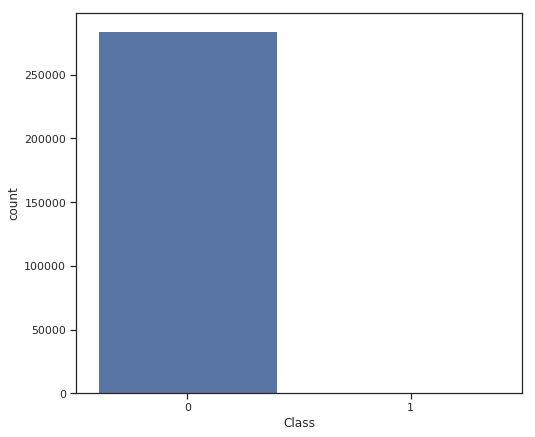

In [312]:
sns.countplot(df['Class']);

Оценим, насколько мошеннические транзакции коррелируют со временем:

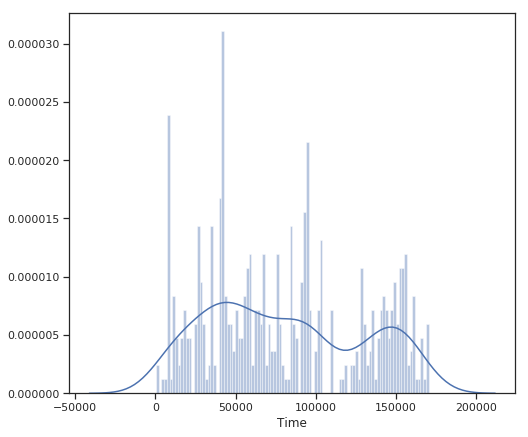

In [313]:
sns.distplot(df[df['Class']==1]['Time'],100);

Посмотрим как пространство признаков изображается при двумерной проекции(на примере признаков 'V11', 'V12', 'V13', 'V14', 'V15') :

In [314]:
# %%time

# rcParams['figure.figsize'] = 12,12
# sns_plot = sns.pairplot(df,vars=['V11', 'V12', 'V13', 'V14', 'V15'],hue="Class",markers=["o", "s"])
# rcParams['figure.figsize'] = 8,7

In [315]:
df = df.sample(n=10000,random_state = r_state)

In [316]:
X_original_unb,y_original_unb,X_original_b,y_original_b = create_balanced_data_from_initial(df)

In [ ]:
%%time
tsne = TSNE(random_state=17)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(['Class'],axis=1))
tsne_representation = tsne.fit_transform(X_scaled)

In [ ]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=df['Class'].map({0: 'blue', 1: 'orange'}));

Для получения качественных оценок работы алгоритма, я буду сравнивать такие метрики как:
- **Recall score**

   Это оценка вида: 
   
   $$score = {tp \over tp + fn}$$
   
   tp - число предсказаний, когда модель верно обнаружила нужные транзакции.
   
   fn - число предсказаний, когда модель не распознала поддельный перевод.
   
   Чем ближе это значение к 1, тем меньше модель пропускает поддельных транзакций. Но, возможно, она будет помечать некоторые переводы как поддельные, хотя они таковыми не являются. Следующие метрики должны помочь проконтролировать этот аспект.
   
   
- **Precision score**

   Это оценка вида: 
   
   $$score = {tp \over tp + fp}$$
   
   Чем ближе к 1 это значение, тем меньше законных транзакций помечаются как поддельные

   
- **Accuracy**

   Доля верных ответов, будем его тоже учитывать.
   
   
- **ROC AUC score**

   Площадь, ограниченная ROC-кривой и осью доли ложных положительных классификаций.
   Эта метрика позволяет судить о качестве бинарной классификации и в совокупности с Recall score  и Precision score должна дать нам наглядное представление о работе классификатора.

Для того, что получить сбалансированный датасет, я буду использовать алгоритм ADASYN(Adaptive Synthetic Sampling),поскольку SMOTE (Synthetic Minority Over-sampling Technique) создает больше примеров внутри кластера, а ADASYN создает больше синтетических примеров на границе. 

В случае, когда данные генерируются ADASYN, модель становится более "подозрительной", поскольку будет лучше опознавать мошеннические транзакции на границе двух кластеров, ведь ADASYN может расширить границы имеющего кластера. Хотя это и может привести к ошибкам рода False Positive, мне кажется, что такой подход будет надежнее и более подходит для предотвращения мошенничества.

Производить оценку метрик я буду на трех датасетах.

1. На исходном
2. На тестовой части датасета.
3. На датасете, полученным контатенацией равных долей поддельных транзакций и неподдельных. То есть, я соединил все поддельные транзакции с тем же числом неподдельных. Это нужно, чтобы посмотреть на оценки в случае, когда число поддельных и неподдельных транзакций сбалансированно и данные оригинальные, в таком случае они более точны, поскольку у модели нет возможности предсказывать, допустим только "0" и при этом показывать хорошие результаты. (функция ниже)

In [246]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
38710,39508.0,1.256599,-0.459633,0.034343,-0.679387,-0.540739,-0.788283,-0.043170,-0.284879,-1.281635,...,-0.120414,-0.541204,0.083329,0.081405,0.292899,-0.511416,-0.004071,0.025408,79.95,0
252425,155803.0,-1.463177,0.755733,1.148214,0.491549,1.216403,0.562360,0.523490,0.378477,-1.819088,...,-0.122225,-0.359679,0.095992,0.175585,0.371695,2.229715,-0.527741,-0.329794,12.19,0
251320,155307.0,-2.231241,0.378645,0.244558,-2.323649,-1.106478,-0.325771,-0.719739,0.820389,-0.612119,...,0.089804,-0.075685,0.082920,-0.446963,-0.439551,-0.631648,-0.586523,0.031298,40.99,0
80239,58392.0,-0.378529,0.684139,0.918082,0.862886,0.969763,0.764045,0.554953,0.191015,-0.199820,...,-0.069716,-0.053133,-0.279469,-1.322809,0.086468,-0.196109,0.158715,0.125476,23.17,0
209783,137706.0,1.930906,0.710091,-0.757991,3.730161,0.512661,-0.492584,0.434969,-0.306465,-1.312444,...,0.248510,0.764477,0.040288,0.068275,0.161119,0.124702,-0.040235,-0.047636,14.41,0


In [247]:
def plot_confusion_matrix(cm, classes=[0,1],
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [248]:
# Соединим строки поддельных с переводов исходного датасета с таким же количеством неподдельных
def create_balanced_data_from_initial(data):
    
    fraud = data[(data['Class']==1)]
    not_fraud = data[(data['Class']==0)]
    
    n_fraud = len(fraud)//2
    

    X_original_unb = pd.concat([fraud[n_fraud:].drop(['Class'], axis=1),not_fraud[n_fraud:].drop(['Class'], axis=1)])
    
    y_original_unb = pd.concat([fraud[n_fraud:]['Class'],not_fraud[n_fraud:]['Class']])
    
    X_original_b = pd.concat([fraud[:n_fraud-1].drop(['Class'], axis=1),not_fraud[:n_fraud-1].drop(['Class'], axis=1)])
    
    y_original_b = pd.concat([fraud[:n_fraud-1]['Class'],not_fraud[:n_fraud-1]['Class']])
    

    return X_original_unb,y_original_unb,X_original_b,y_original_b
    

In [249]:
# Применение алгоритма ADASYN
def create_balanced_data_adasyn(x,y):
    sm = ADASYN(random_state=12, ratio = 'minority')
    X,Y = sm.fit_sample(x, y)
    X = pd.DataFrame(X,columns = ['Time','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'] )
    Y = pd.DataFrame(Y,columns = ['Class'])
    return X,Y

In [250]:
def create_balanced_data_smote(x,y):
    sm = SMOTE(random_state=12, ratio = 'minority')
    X,Y = sm.fit_sample(x, y)
    X = pd.DataFrame(X,columns = ['Time','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'] )
    Y = pd.DataFrame(Y,columns = ['Class'])
    return X,Y

In [282]:
# def all_metrics_validation(clf,X,Y_true):
# #     pass
#     print("Accuracy score: "+ str(accuracy_score(Y_true,clf.predict(X))))
    
#     print("ROC AUC score: "+ str(roc_auc_score(Y_true,clf.predict_proba(X)[:,1])))
#     # нас интересуют положительные результаты
#     print("Recall score: "+ str(recall_score(Y_true,clf.predict(X))))
    
#     print("Precicion score: "+ str(precision_score(Y_true,clf.predict(X))))

In [283]:
# Оценка модели на указанных датасетах
def estimate_model(clf, X_original_b,y_original_b,  X_test, y_test):

    print("ROC AUC score: "+ str(roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])))
    print(classification_report(y_test,clf.predict(X_test)))

In [285]:
# Разделим на тестовую и тренировочную
X_train, X_test, y_train, y_test = train_test_split(X_original_unb,y_original_unb, test_size=0.3)

Далее, при генерации данных ADASYN и SMOTE, необходимо сначала отделить тестовую и проверочную выборки, а затем для тренировочной сгенерировать новые данные. Тк в противном случае, если сначала создать новых данных, а потом разделить выборку, то синтетические данные попадут в проверочный сет.

In [286]:
datasets = {'NOT SYNTHETIC DATA':(X_train,y_train),
          'ADASYN': create_balanced_data_adasyn(X_train, y_train),
          'SMOTE': create_balanced_data_smote(X_train, y_train)}
    


In [287]:
type(datasets['ADASYN'])

tuple

StratifiedKFold - сохраняет процент образцов в тестовом и тренировочных сетах, поэтому такому кросс-валиждатору можно доверять

# ADASYN

## Случайный лес


++++++++++++++++++++++
ADASYN
ROC AUC score: 0.9992151527835915
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2389
          1       0.57      1.00      0.73         4

avg / total       1.00      1.00      1.00      2393


++++++++++++++++++++++
NOT SYNTHETIC DATA
ROC AUC score: 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2389
          1       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00      2393


++++++++++++++++++++++
SMOTE
ROC AUC score: 0.9989535370447886
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2389
          1       0.57      1.00      0.73         4

avg / total       1.00      1.00      1.00      2393



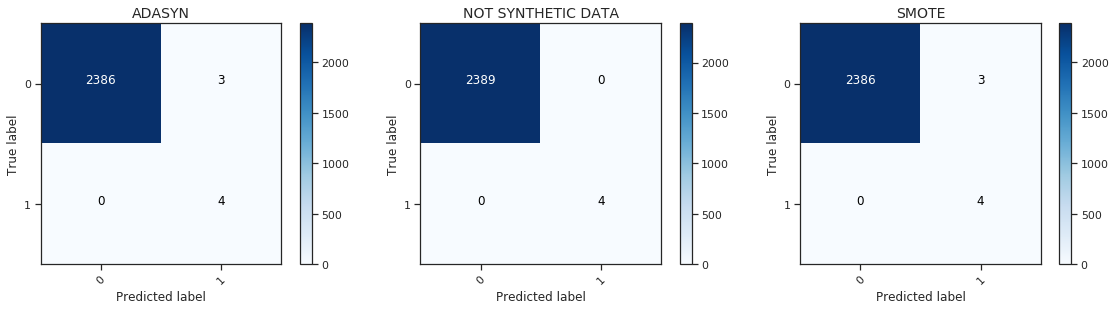

CPU times: user 3.94 s, sys: 1.49 s, total: 5.44 s
Wall time: 12 s


In [288]:
%%time
parameters = {"max_depth": [3,5, None],
              "n_estimators":[15,16,20],
              "max_features": [6,7,8],
              'n_jobs':[-1]}


skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=r_state)

rfc = RandomForestClassifier()

gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=0,scoring='recall')
fig = plt.figure(figsize=(16,8))
j=1

for key in sorted(datasets):
    print('\n++++++++++++++++++++++')
    print(key)
    
    gcv.fit(datasets[key][0],datasets[key][1])
    
    best_rfc = gcv.best_estimator_   
    
     print(key,gcv.best_params_ , gcv.best_score_)
    
    estimate_model(gcv.best_estimator_ , X_original_b,y_original_b, X_test, y_test)
    
    conf_matrix = confusion_matrix(y_test,gcv.best_estimator_.predict(X_test))
   
    fig.add_subplot(2,3,j)
    j += 1

    plot_confusion_matrix(conf_matrix, title=key)
plt.show()    

    

## Метод ближайших соседей


++++++++++++++++++++++
ADASYN
ADASYN {'n_jobs': -1, 'n_neighbors': 16} 0.6574604808622269
ROC AUC score: 0.7576391795730432
             precision    recall  f1-score   support

          0       1.00      0.84      0.91      2389
          1       0.01      0.75      0.02         4

avg / total       1.00      0.84      0.91      2393


++++++++++++++++++++++
NOT SYNTHETIC DATA
NOT SYNTHETIC DATA {'n_jobs': -1, 'n_neighbors': 10} 0.0
ROC AUC score: 0.49372122226873166
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2389
          1       0.00      0.00      0.00         4

avg / total       1.00      1.00      1.00      2393


++++++++++++++++++++++
SMOTE
SMOTE {'n_jobs': -1, 'n_neighbors': 16} 0.6710313901345292
ROC AUC score: 0.7469129342821264
             precision    recall  f1-score   support

          0       1.00      0.82      0.90      2389
          1       0.01      0.75      0.01         4

avg / total       1.00    

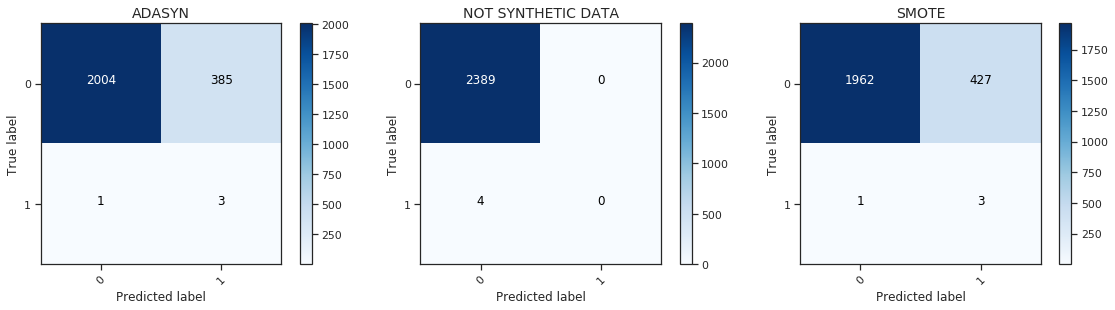

CPU times: user 2.72 s, sys: 1.57 s, total: 4.29 s
Wall time: 3.36 s


In [295]:
%%time
parameters = {'n_neighbors': range(10,30,10),'n_jobs':[-1]}

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=r_state)

knn = KNeighborsClassifier()

gcv = GridSearchCV(knn, parameters, n_jobs=-1, cv=skf, verbose=0,scoring='recall')

fig = plt.figure(figsize=(16,8))
j=1

for key in sorted(datasets):
    print('\n++++++++++++++++++++++')
    print(key)
    
    gcv.fit(datasets[key][0],datasets[key][1])
    
    best_knn = gcv.best_estimator_   
    
    print(key,gcv.best_params_ , gcv.best_score_)
    
    estimate_model(gcv.best_estimator_ , X_original_b,y_original_b, X_test, y_test)
    
    conf_matrix = confusion_matrix(y_test,gcv.best_estimator_.predict(X_test))
   
    fig.add_subplot(2,3,j)
    j += 1

    plot_confusion_matrix(conf_matrix, title=key)
plt.show()    


## Логистическая регрессия


++++++++++++++++++++++
ADASYN
Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.7s finished


ROC AUC score: 0.9992674759313521
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2389
          1       0.50      1.00      0.67         4

avg / total       1.00      1.00      1.00      2393


++++++++++++++++++++++
NOT SYNTHETIC DATA
Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.5s finished


ROC AUC score: 0.9987442444537463
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2389
          1       0.60      0.75      0.67         4

avg / total       1.00      1.00      1.00      2393


++++++++++++++++++++++
SMOTE
Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.7s finished


ROC AUC score: 0.9993721222268731
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2389
          1       0.50      1.00      0.67         4

avg / total       1.00      1.00      1.00      2393



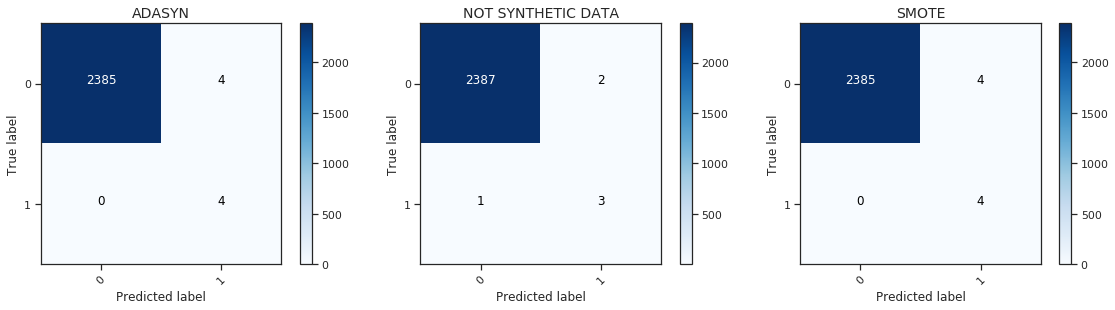

CPU times: user 1.64 s, sys: 1.74 s, total: 3.39 s
Wall time: 3.36 s


In [290]:
%%time
logit = LogisticRegression(n_jobs=-1)       

parameters = {'C': [5,10,20,30],'penalty':['l1', 'l2']}

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=r_state)

gcv = GridSearchCV(logit, parameters, n_jobs=-1, cv=skf, verbose=0,scoring='recall')

fig = plt.figure(figsize=(16,8))
j=1

for key in sorted(datasets):
    print('\n++++++++++++++++++++++')
    print(key)
    
    gcv.fit(datasets[key][0],datasets[key][1])
    
    best_logit = gcv.best_estimator_   
    
     print(key,gcv.best_params_ , gcv.best_score_)
    
    estimate_model(gcv.best_estimator_ , X_original_b,y_original_b, X_test, y_test)
    
    conf_matrix = confusion_matrix(y_test,gcv.best_estimator_.predict(X_test))
   
    fig.add_subplot(2,3,j)
    j += 1

    plot_confusion_matrix(conf_matrix, title=key)
plt.show()    


## Нейросеть



Поскольку перед нами не стоит задача распознавания изображений, у нас не так много данных и они не имею слишком большой размерности, то воспользуемся встроенной в SKlearn нейросетью - MultiLayerClassifier


++++++++++++++++++++++
ADASYN
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.8s finished


ROC AUC score: 0.6235872750104647
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2389
          1       0.00      0.00      0.00         4

avg / total       1.00      1.00      1.00      2393


++++++++++++++++++++++
NOT SYNTHETIC DATA
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.1s finished


ROC AUC score: 0.6069485140226036
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2389
          1       0.00      0.00      0.00         4

avg / total       1.00      1.00      1.00      2393


++++++++++++++++++++++
SMOTE
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.9s finished


ROC AUC score: 0.3969233989116786
             precision    recall  f1-score   support

          0       1.00      0.51      0.67      2389
          1       0.00      0.75      0.01         4

avg / total       1.00      0.51      0.67      2393



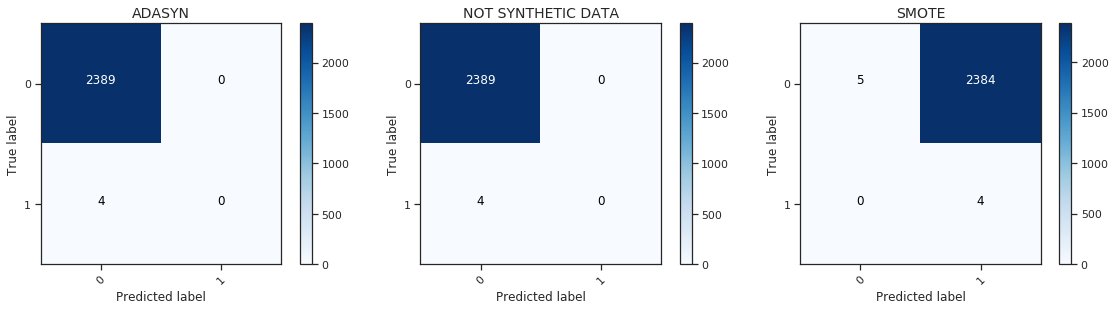

CPU times: user 2.16 s, sys: 1.81 s, total: 3.97 s
Wall time: 7.92 s


In [291]:
%%time

scaler = RobustScaler()
scaler.fit_transform(X_train_adasyn['Amount'].values.reshape(-1, 1))
# rob_scaler.fit_transform(X_train_adasyn['Time'].values.reshape(-1, 1))


mlp = MLPClassifier(random_state=r_state)
parameters = {'activation':['logistic'], 'alpha':[1e-5],'hidden_layer_sizes':[(10,),(10,30,10,),(40,100,)],'learning_rate':['adaptive']}

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=r_state)

gcv = GridSearchCV(mlp, parameters, n_jobs=-1, cv=skf, verbose=1,scoring='recall')

fig = plt.figure(figsize=(16,8))
j=1

for key in sorted(datasets):
    print('\n++++++++++++++++++++++')
    print(key)
    
    gcv.fit(datasets[key][0],datasets[key][1])
    
    best_mlp = gcv.best_estimator_   
    
    print(key,gcv.best_params_ , gcv.best_score_)
    
    estimate_model(gcv.best_estimator_ , scaler.transform(X_original_b),y_original_b, scaler.transform(X_test),y_test)
    
    conf_matrix = confusion_matrix(y_test,gcv.best_estimator_.predict(X_test))
   
    fig.add_subplot(2,3,j)
    j += 1

    plot_confusion_matrix(conf_matrix, title=key)
plt.show()    
